In [1]:
from matplotlib.dates import date2num, num2date
from matplotlib.colors import ListedColormap
from matplotlib import dates as mdates
from matplotlib.patches import Patch
from matplotlib import pyplot as plt
from matplotlib import ticker

from urllib.request import urlopen
from unidecode import unidecode

import pandas as pd
import numpy as np
import itertools
import re
import os

import pymmwr as pm
import urllib

import sys

sys.path.insert(0, '../')

from global_config import config
from itertools import chain

results_dir   = config.get_property('results_dir')
data_dir      = config.get_property('data_dir')

plt.rc('font', size=15)

In [2]:
def flat_list(list_of_lists):
    return list(chain(*list_of_lists))

In [3]:
def binomial_transition(var, rate, dt=1, num_ensembles=300):
    kb        = np.maximum(1.0 - np.exp(-rate*dt), 0)
    num_ind   = np.random.binomial(list(var), kb )
    if num_ind.shape[-1]!=num_ensembles:
        print("Error transitioning stochastic model")
    return np.squeeze(num_ind)

def imd_model(x, betas, theta, N, dt=1):
    """[summary]

    Args:
        x ([type]):           Dimension of [num_state_variables, num_ensembles]
        betas ([type]):       Dimension of [num_state_variables, num_ensembles]
        pop_pyramid ([type]): Dimension of [num_state_variables, num_ensembles]

    Returns:
        [type]: [description]
    """

    # Infection duration.
    gamma   = 1/15

    # Carriage duration.
    alpha1   = 1/150
    alpha2   = 1/10

    S       = x[0, :] # Susceptible  [1, num_ensembles]
    C       = x[1, :] # Carriers     [1, num_ensembles]
    I       = x[2, :] # Infected     [1, num_ensembles]

    # Force of Infection
    foi =  betas * (C + I) / N

    ############ TRANSITIONS ############
    s2c   =  binomial_transition(S, dt * foi)                # susceptible to colonized with vaccine preventable strain
    c2i   =  binomial_transition(C, dt * alpha2 * theta)     # colonized to infected with vaccine preventable strain
    c2s   =  binomial_transition(C, dt * alpha1 * (1-theta)) # colonized to susceptible due to decolonization
    i2s   =  binomial_transition(I, dt * gamma)              # infected to susceptible due to infection clearance

    S     = S  - s2c  + c2s + i2s
    C     = C  + s2c  - c2i - c2s
    I     = I  + c2i   - i2s
    inc   = c2i

    return np.array([S , C , I , inc])



In [4]:
from scipy.stats import truncnorm

def compute_oev(obs_vec, var_obs=0.2):
    return 1 + (var_obs*obs_vec)**2

def checkbound_params(dict_params_range, params_ens, num_ensembles=300):
    params_update = []
    for idx_p, p in enumerate(dict_params_range.keys()):
        loww = dict_params_range[p][0]
        upp  = dict_params_range[p][1]

        p_ens = params_ens[idx_p, :].copy()

        idx_wrong      = np.where(np.logical_or(p_ens <loww, p_ens > upp))[0]

        idx_wrong_loww = np.where(p_ens < loww)[0]
        idx_wrong_upp  = np.where(p_ens > upp)[0]

        idx_good  = np.where(np.logical_or(p_ens >=loww, p_ens <= upp))[0]

        p_ens[idx_wrong] = np.median(p_ens[idx_good])

        np.put(p_ens, idx_wrong_loww, loww * (1+0.2*np.random.rand( idx_wrong_loww.shape[0])) )
        np.put(p_ens, idx_wrong_upp, upp * (1-0.2*np.random.rand( idx_wrong_upp.shape[0])) )

        params_update.append(p_ens)

    return np.array(params_update)

def checkbound_state_vars(x_state_ens, pop):
    loww = 0
    upp  = pop
    x_state_ens = np.clip(x_state_ens, loww, upp)
    return x_state_ens


In [5]:

βmin = 0.006
βmax = 0.01

θmin = 0.5e-6
θmax = 1.2e-6

In [6]:
from utils.utils_infer import create_df_response, get_truncated_normal, sample_params_uniform, sample_params_normal, eakf_step, checkbound_params
from tqdm import tqdm

data_df = pd.read_csv(os.path.join(data_dir, 'processed_data_us.csv'), parse_dates=['date'])
this_df = data_df.copy()
this_df           = this_df.rename(columns={"total": "confirmed"})
this_df["oev"]    = compute_oev(this_df["confirmed"].values)

population    = 200e6
theta         = 1e-2
beta          = 0.85
m             = 300

days_simulation       = list(pd.date_range(start=pd.to_datetime("2006-01-01"), end=this_df.iloc[-1]["date"]))
data_assimilation_df  = this_df.copy()
data_assimilation_df  = data_assimilation_df.set_index("date")
dates_assimilation    = data_assimilation_df.index.values

idx_date_update = 0

dict_params_range = {}
dict_params_range["beta"]  = [βmin,  βmax]
dict_params_range["theta"] = [θmin, θmax]

state_params_range       = {}
state_params_range["S0"] = [80/100, 95/100]


param_prior = sample_params_uniform(dict_params_range, num_ensembles=m)
obs_t = np.zeros((m))

p = 2
n = 4

num_steps        = len(data_assimilation_df)
param_post_time  = np.zeros((p, m,    num_steps))
x_post_time      = np.zeros((n, m, num_steps))
obs_post_time    = np.zeros((1, m, num_steps))


idx_date_update = 0
obs_t           = np.zeros((m))

#S0     = np.ones(( num_ensembles) ) * population
S0     = np.squeeze(population * sample_params_uniform(state_params_range, m))
C0     = np.squeeze((1 - sample_params_uniform(state_params_range, m))*population)
I0     = np.zeros((m))

inc    = np.zeros((m))
x0     = np.array([S0, C0, I0, inc]) # array with initial conditions [num_state_variables, num_age_groups]
x      = x0

x_prior = np.zeros((n, m))
for idx_date, date in tqdm(enumerate(dates_assimilation)):
        betas  = param_prior[0, :].copy()
        thetas = param_prior[1, :].copy()

        x_prior = imd_model(x, betas, thetas, N=population, dt=30)
        x       = x_prior.copy()
        obs_t   += x[-1,:]

        # Since the age groups are an index, the arrangement of the age groups remains.
        oev_confirmed_time = data_assimilation_df.loc[date]["oev"]
        confirmed_time     = data_assimilation_df.loc[date]["confirmed"]

        x_post, param_post, obs_post = eakf_step(x_prior, param_prior, obs_t, confirmed_time, oev_confirmed_time, dict_params_range, num_var=4)
        S       = x_post[0, :] # Susceptible  [1, num_ensembles]
        C       = x_post[1, :] # Carriers     [1, num_ensembles]
        I       = x_post[2, :] # Infected     [1, num_ensembles]
        x_post[0, :] = population*np.ones(S.shape) - C - I # re-adjust susceptibility

        x_post                       = checkbound_state_vars(x_post, population)
        param_post                   = checkbound_params(dict_params_range, param_post, num_ensembles=300)

        x = x_post.copy()

        # Use posterior and next prior
        param_prior  = param_post.copy()

        obs_post_time[:,:,idx_date_update]      = obs_post
        param_post_time[:,:,idx_date_update]    = param_prior
        x_post_time[:,:,idx_date_update]        = x_post

        idx_date_update += 1
        obs_t           = np.zeros((m))


202it [00:00, 361.81it/s]


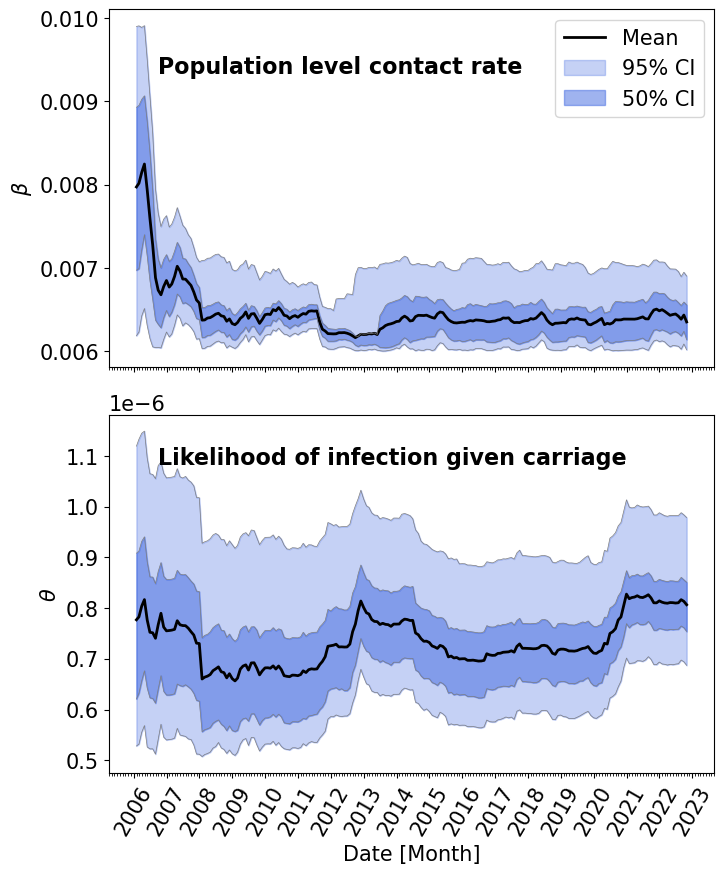

In [7]:
from matplotlib.dates import date2num, num2date
from matplotlib.colors import ListedColormap
from matplotlib import dates as mdates
from matplotlib.patches import Patch
from matplotlib import pyplot as plt
from matplotlib import ticker
import seaborn as sns


S_post   = x_post_time[0, :]; S_df = create_df_response(S_post, time= num_steps).reset_index();   S_df["date"] = dates_assimilation
C_post   = x_post_time[1, :]; C_df = create_df_response(C_post, time= num_steps).reset_index();   C_df["date"] = dates_assimilation
I_post   = x_post_time[2, :]; I_df = create_df_response(I_post, time= num_steps).reset_index();   I_df["date"] = dates_assimilation
inc_post = x_post_time[3, :]; inc_df = create_df_response(inc_post, time= num_steps).reset_index(); inc_df["date"] = dates_assimilation


beta_df  = create_df_response(param_post_time[0,:], time=num_steps).reset_index();       beta_df["date"]  = dates_assimilation
theta_df = create_df_response(param_post_time[1,:], time=num_steps).reset_index();       theta_df["date"] = dates_assimilation
obs_df   = create_df_response(np.squeeze(obs_post_time), time=num_steps).reset_index();  obs_df["date"] = dates_assimilation


fig, ax = plt.subplots(2, 1, figsize=(7.5, 9), sharex=True)
ax[0].plot(beta_df.date, beta_df["mean"], color="k", lw=2, label="Mean")
ax[0].fill_between(beta_df.date, beta_df["low_95"], beta_df["up_95"], color="royalblue", alpha=0.3, label="95% CI"); ax[0].plot(beta_df.date, beta_df["up_95"], color="gray", lw=0.5); ax[0].plot(beta_df.date, beta_df["low_95"], color="gray", lw=0.5)
ax[0].fill_between(beta_df.date, beta_df["low_50"], beta_df["up_50"], color="royalblue", alpha=0.5, label="50% CI"); ax[0].plot(beta_df.date, beta_df["up_50"], color="gray", lw=0.5); ax[0].plot(beta_df.date, beta_df["low_50"], color="gray", lw=0.5)

ax[1].plot(theta_df.date, theta_df["mean"], color="k", lw=2, label="Mean")
ax[1].fill_between(theta_df.date, theta_df["low_95"], theta_df["up_95"], color="royalblue", alpha=0.3, label="95% CI"); ax[1].plot(theta_df.date, theta_df["up_95"], color="gray", lw=0.5); ax[1].plot(theta_df.date, theta_df["low_95"], color="gray", lw=0.5)
ax[1].fill_between(theta_df.date, theta_df["low_50"], theta_df["up_50"], color="royalblue", alpha=0.5, label="50% CI"); ax[1].plot(theta_df.date, theta_df["up_50"], color="gray", lw=0.5); ax[1].plot(theta_df.date, theta_df["low_50"], color="gray", lw=0.5)

ax[0].set_ylabel(r"$\beta$")
ax[1].set_ylabel(r"$\theta$")

ax[-1].set_xlabel("Date [Month]")

ax[0].text(theta_df.date.iloc[8], βmax - (βmax-βmin)/6, r'Population level contact rate', fontweight="bold", fontsize=16)
ax[1].text(theta_df.date.iloc[8], θmax - (θmax-θmin)/6, r'Likelihood of infection given carriage', fontweight="bold", fontsize=16)

for axi in ax.flatten():
    axi.legend(loc="upper right")
    axi.tick_params(which='both', axis='x', labelrotation=60, labelsize=15)
    axi.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    axi.xaxis.set_minor_locator(mdates.MonthLocator())
    axi.xaxis.set_major_locator(mdates.YearLocator())
ax[0].legend(loc="upper right")
ax[1].legend().remove()

plt.tight_layout()
fig.savefig(os.path.join(results_dir, "figures", "model1", "ppost_eakf.png"), dpi=300, transparent=True)

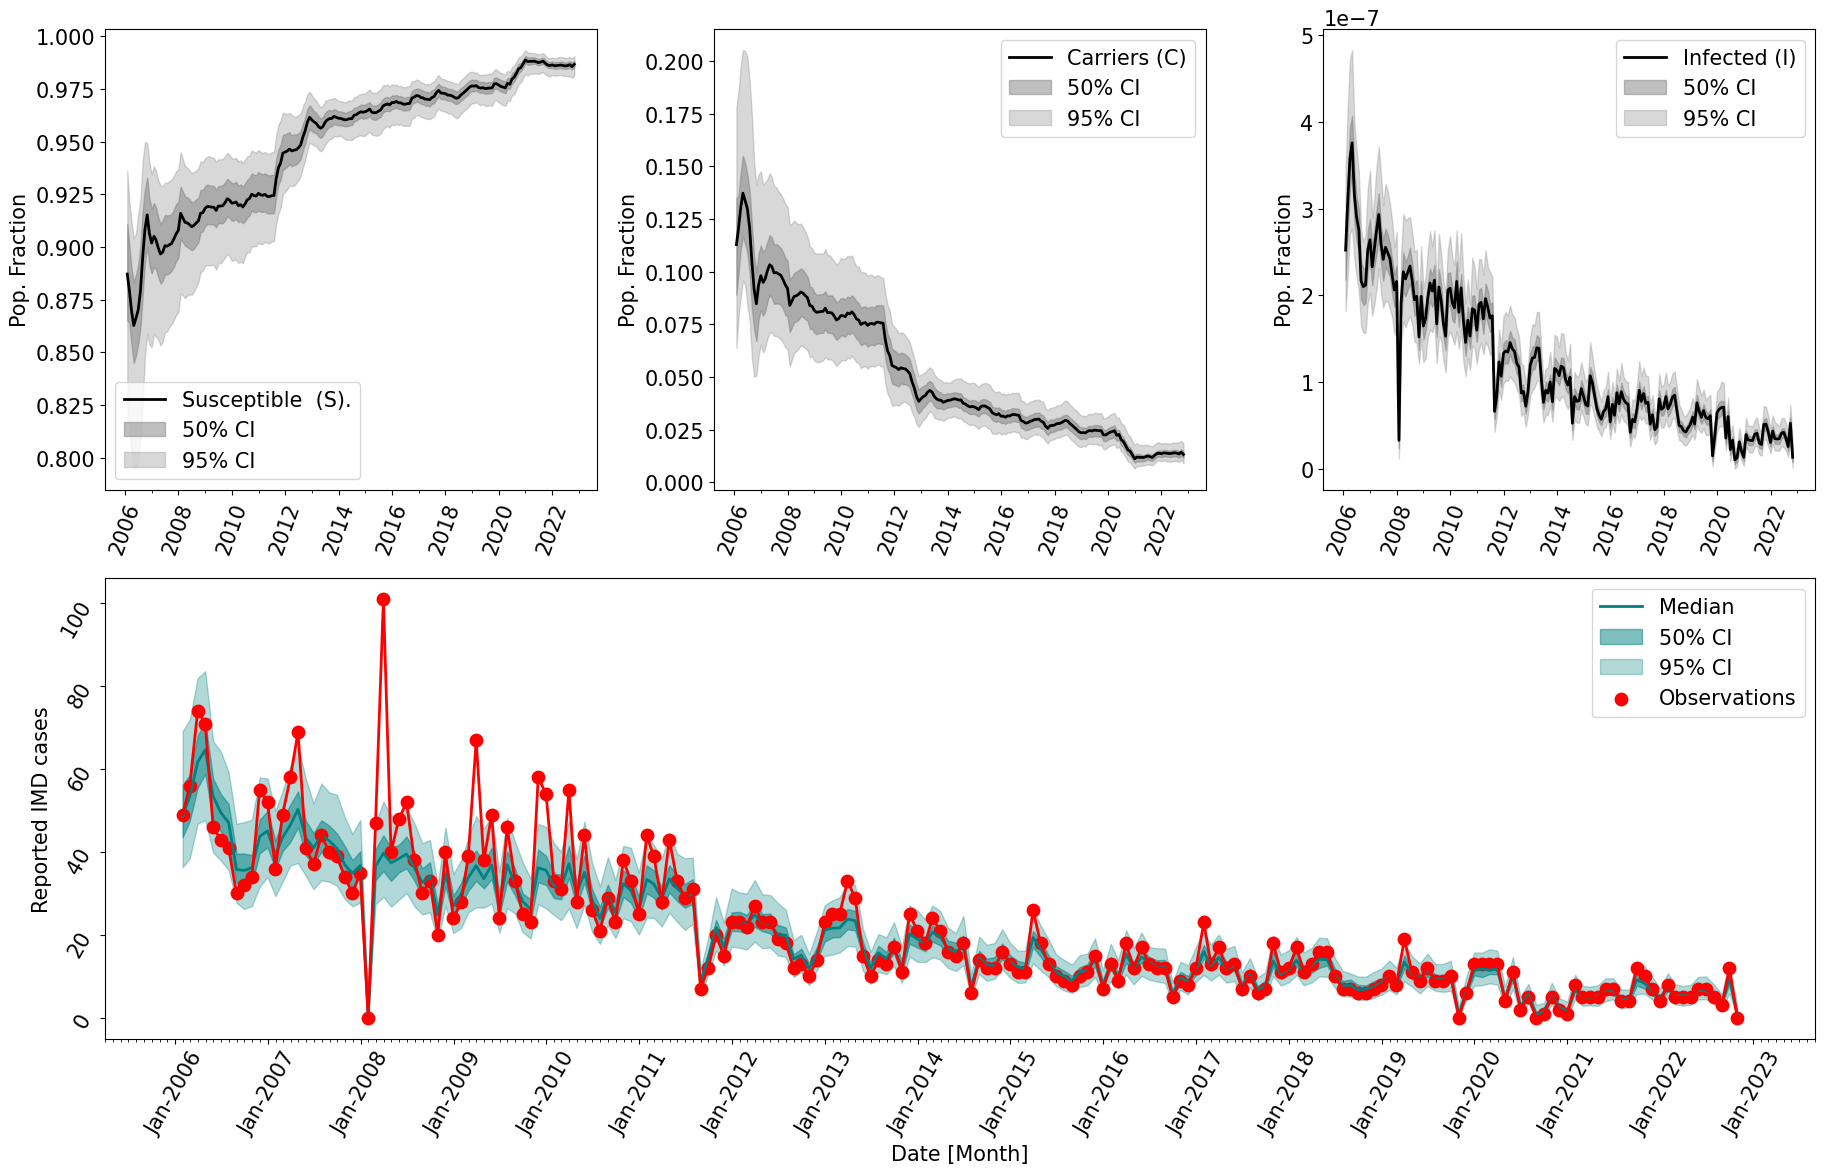

In [8]:

fig = plt.figure(figsize=(18.5, 12))

ax1 = plt.subplot(231)
ax2 = plt.subplot(232)
ax3 = plt.subplot(233)
ax4 = plt.subplot(212)

ax1.plot(S_df.date,         S_df["mean"]   / population, color="k", lw=2, label="Susceptible  (S).")
ax1.fill_between(S_df.date, S_df["low_50"] / population, S_df["up_50"] / population, color="gray", alpha=0.5, label="50% CI")
ax1.fill_between(S_df.date, S_df["low_95"] / population, S_df["up_95"] / population, color="gray", alpha=0.3, label="95% CI")
ax1.set_ylabel("Pop. Fraction")

ax2.plot(C_df.date,         C_df["mean"] / population, color="k", lw=2, label="Carriers (C)")
ax2.fill_between(C_df.date, C_df["low_50"] / population, C_df["up_50"] / population, color="gray", alpha=0.5, label="50% CI")
ax2.fill_between(C_df.date, C_df["low_95"] / population, C_df["up_95"] / population, color="gray", alpha=0.3, label="95% CI")

ax2.set_ylabel("Pop. Fraction")

ax3.plot(I_df.date, I_df["mean"]/population, color="k", lw=2, label="Infected (I)")
ax3.fill_between(I_df.date, I_df["low_50"]/population, I_df["up_50"]/population, color="gray", alpha=0.5, label="50% CI")
ax3.fill_between(I_df.date, I_df["low_95"]/population, I_df["up_95"]/population, color="gray", alpha=0.3, label="95% CI")

ax3.set_ylabel("Pop. Fraction")


ax4.plot(inc_df.date, inc_df["median"],                          color="teal", lw=2, label="Median")
ax4.fill_between(inc_df.date, inc_df["low_50"], inc_df["up_50"], color="teal", alpha=0.5, label="50% CI")
ax4.fill_between(inc_df.date, inc_df["low_95"], inc_df["up_95"], color="teal", alpha=0.3, label="95% CI")

ax4.scatter(data_assimilation_df.index.values, data_assimilation_df["confirmed"], ec="red", fc="red", s=80, label="Observations")
ax4.plot(data_assimilation_df.index.values, data_assimilation_df["confirmed"], linestyle="-", color="red", lw=2)

ax4.set_ylabel("Reported IMD cases")

ax1.legend()
ax2.legend()
ax3.legend()

for axi in [ax1, ax2, ax3]:
    axi.tick_params(which='both', axis='x', labelrotation=70, labelsize=15)
    axi.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    axi.xaxis.set_minor_locator(mdates.YearLocator())

ax4.tick_params(which='both', axis='both', labelrotation=60, labelsize=15)
ax4.xaxis.set_major_formatter(mdates.DateFormatter('%b-%Y'))
ax4.xaxis.set_minor_locator(mdates.MonthLocator())
ax4.xaxis.set_major_locator(mdates.YearLocator())
ax4.set_xlabel("Date [Month]")
ax4.legend(loc="upper right")

plt.tight_layout()
fig.savefig(os.path.join(results_dir, "figures", "model1", "statespace_posterior_eakf.png"), dpi=300, transparent=True)


In [9]:
pop   = 200e6

# Simulate with MLE
S0     = np.squeeze(pop * sample_params_uniform(state_params_range, m))
C0     = np.squeeze((1 - sample_params_uniform(state_params_range, m))*pop)
I0     = np.zeros((m))
inc    = np.zeros((m))
x0     = np.array([S0, C0, I0, inc]) # array with initial conditions [num_state_variables, num_age_groups]
x      = x0

x_time = np.full((n, m, len(dates_assimilation)+1), np.nan)
x_time[:,:,0] = x

for idx_t, date in enumerate(dates_assimilation):

    betas  = param_post_time[0, :, idx_t]
    thetas = param_post_time[1, :, idx_t]

    # Integrate model
    x_time[:, :, idx_t+1] = imd_model(np.minimum(x_time[:,:,idx_t], population), betas, thetas, N=population, dt=30)


S_post   = x_time[0, :, 1:]; S_df = create_df_response(S_post, time= num_steps);     S_df["date"] = dates_assimilation
C_post   = x_time[1, :, 1:]; C_df = create_df_response(C_post, time= num_steps);     C_df["date"] = dates_assimilation
I_post   = x_time[2, :, 1:]; I_df = create_df_response(I_post, time= num_steps);     I_df["date"] = dates_assimilation
inc_post = x_time[3, :, 1:]; inc_df = create_df_response(inc_post, time= num_steps); inc_df["date"] = dates_assimilation


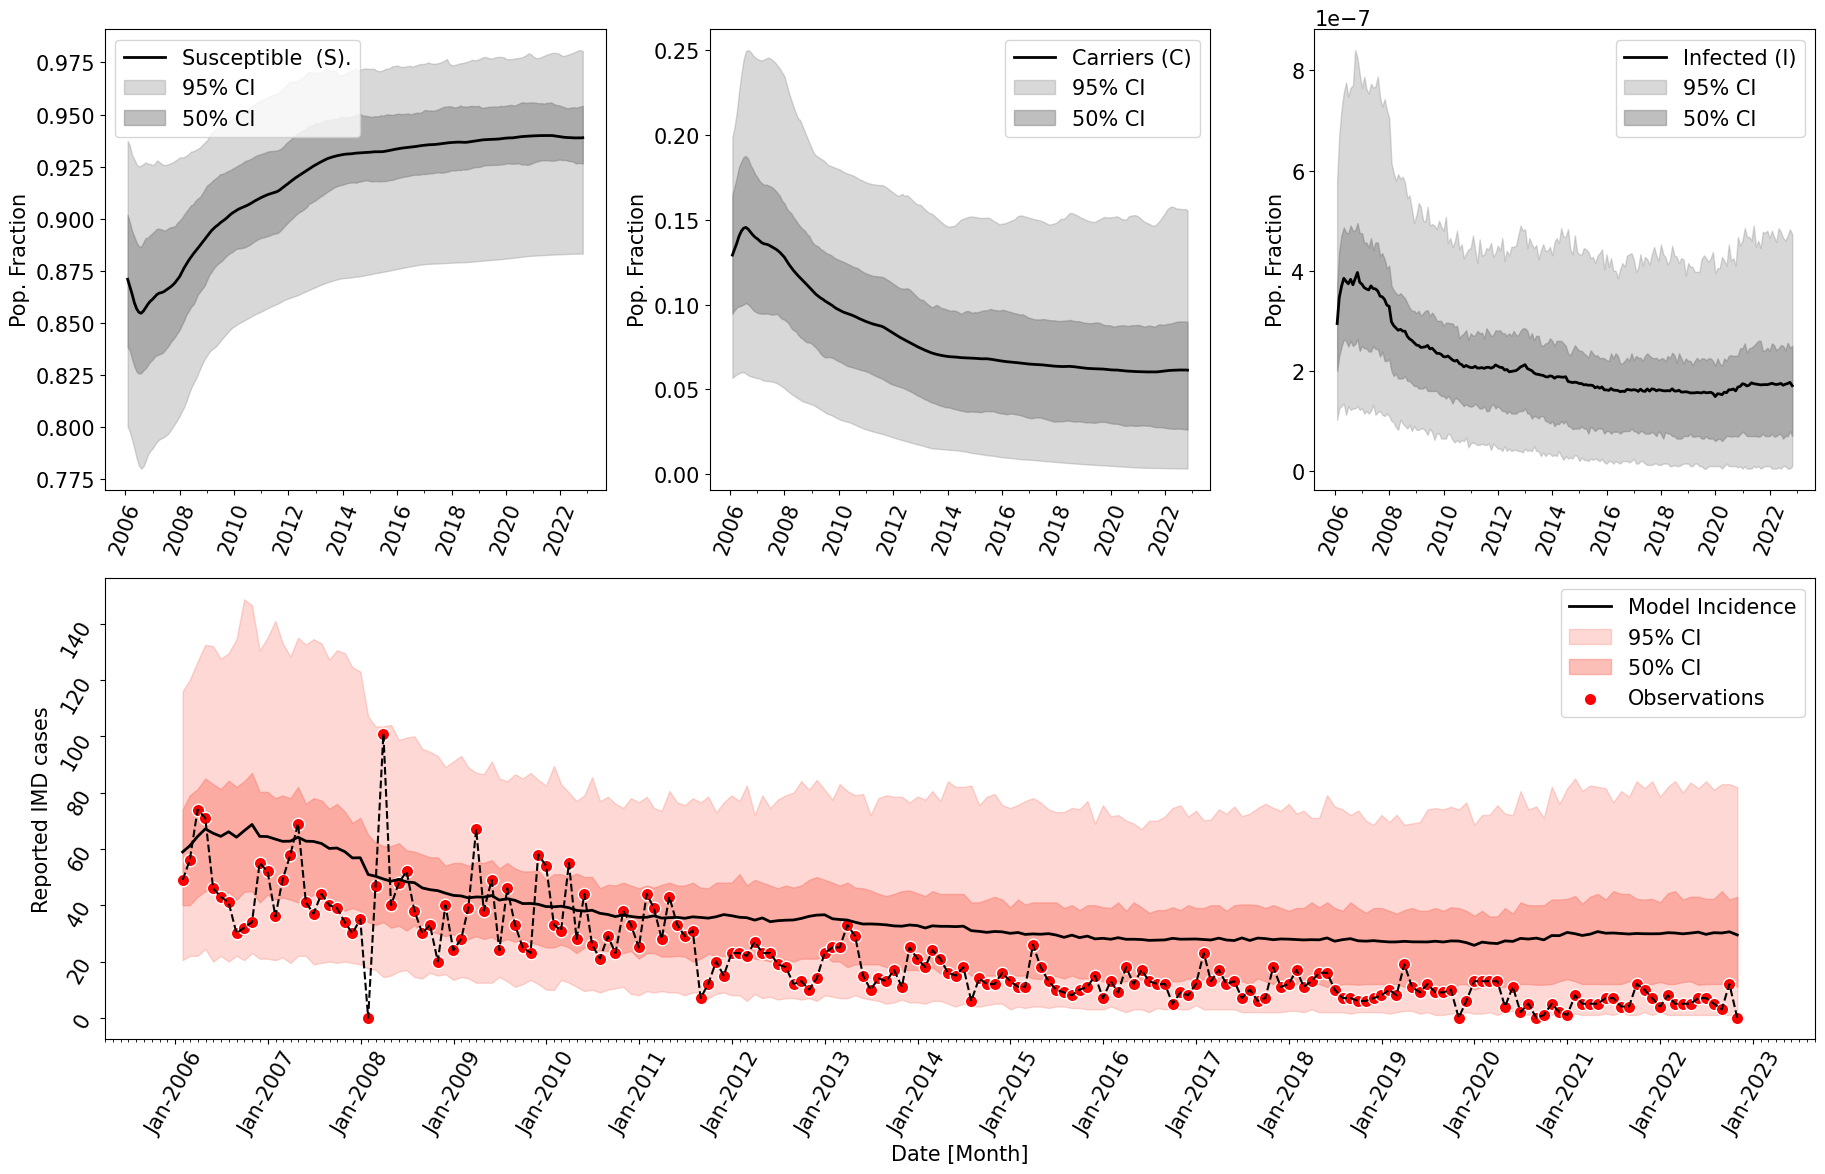

In [10]:
fig = plt.figure(figsize=(18.5, 12))

ax1 = plt.subplot(231)
ax2 = plt.subplot(232)
ax3 = plt.subplot(233)
ax4 = plt.subplot(212)

ax1.plot(S_df.date,         S_df["mean"]   / population, color="k", lw=2, label="Susceptible  (S).")
ax1.fill_between(S_df.date, S_df["low_95"] / population, S_df["up_95"] / population, color="gray", alpha=0.3, label="95% CI")
ax1.fill_between(S_df.date, S_df["low_50"] / population, S_df["up_50"] / population, color="gray", alpha=0.5, label="50% CI")
ax1.set_ylabel("Pop. Fraction")

ax2.plot(C_df.date,         C_df["mean"] / population, color="k", lw=2, label="Carriers (C)")
ax2.fill_between(C_df.date, C_df["low_95"] / population, C_df["up_95"] / population, color="gray", alpha=0.3, label="95% CI")
ax2.fill_between(C_df.date, C_df["low_50"] / population, C_df["up_50"] / population, color="gray", alpha=0.5, label="50% CI")
ax2.set_ylabel("Pop. Fraction")

ax3.plot(I_df.date, I_df["mean"]/population, color="k", lw=2, label="Infected (I)")
ax3.fill_between(I_df.date, I_df["low_95"]/population, I_df["up_95"]/population, color="gray", alpha=0.3, label="95% CI")
ax3.fill_between(I_df.date, I_df["low_50"]/population, I_df["up_50"]/population, color="gray", alpha=0.5, label="50% CI")
ax3.set_ylabel("Pop. Fraction")

ax4.plot(inc_df.date, inc_df["mean"], color="k", lw=2, label="Model Incidence")
ax4.fill_between(inc_df.date, inc_df["low_95"], inc_df["up_95"], color="salmon", alpha=0.3, label="95% CI")
ax4.fill_between(inc_df.date, inc_df["low_50"], inc_df["up_50"], color="salmon", alpha=0.5, label="50% CI")
ax4.scatter(data_assimilation_df.index.values, data_assimilation_df["confirmed"], ec="white", fc="red", s=80, label="Observations")
ax4.plot(data_assimilation_df.index.values, data_assimilation_df["confirmed"], linestyle="--", color="k")

ax4.set_ylabel("Reported IMD cases")

ax1.legend()
ax2.legend()
ax3.legend()

for axi in [ax1, ax2, ax3]:
    axi.tick_params(which='both', axis='x', labelrotation=70, labelsize=15)
    axi.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    axi.xaxis.set_minor_locator(mdates.YearLocator())

ax4.tick_params(which='both', axis='both', labelrotation=60, labelsize=15)
ax4.xaxis.set_major_formatter(mdates.DateFormatter('%b-%Y'))
ax4.xaxis.set_minor_locator(mdates.MonthLocator())
ax4.xaxis.set_major_locator(mdates.YearLocator())
ax4.set_xlabel("Date [Month]")
ax4.legend(loc="upper right")
plt.tight_layout()

fig.savefig(os.path.join(results_dir, "figures", "model1", "ppost_eakf_sim.png"), dpi=300, transparent=True)


In [11]:
def geometric_cooling(num_iteration_if, cooling_factor=0.9):
    alphas = cooling_factor**np.arange(num_iteration_if)
    return alphas**2

def hyperbolic_cooling(num_iteration_if, cooling_factor=0.9):
    alphas = 1/(1+cooling_factor*np.arange(num_iteration_if))
    return alphas

def cooling(num_iteration_if, type_cool="geometric", cooling_factor=0.9):
    if type_cool=="geometric":
        return geometric_cooling(num_iteration_if, cooling_factor=cooling_factor)
    elif type_cool=="hyperbolic":
        return hyperbolic_cooling(num_iteration_if, cooling_factor=cooling_factor)

def random_walk_perturbation(param, param_std, num_params, num_ensembles):
    return param + param_std * np.random.normal(size=(num_params, num_ensembles))

def inflate_ensembles(ens, inflation_value=1.2, num_ensembles=300):
    return np.mean(ens,1, keepdims=True)*np.ones((1,num_ensembles)) + inflation_value*(ens-np.mean(ens,1, keepdims=True)*np.ones((1,num_ensembles)))


from tqdm import tqdm

def IF2_eakf(imd_model, obs_df, param_prior_dict, if2_settings, pop=1e6, perturb_time=True):

    cooling_factor   = cooling(if2_settings["Nif"], type_cool=if2_settings["type_cooling"], cooling_factor=if2_settings["alpha_mif"])
    param_range      = np.array([v for k, v in param_prior_dict.items()])
    std_param        = param_range[:,1]-param_range[:,0]
    SIG              = std_param ** 2 / 4; #  initial covariance of parameters

    perturbation     = np.array([std_param % list(np.round(std_param)+0.1)]).T

    num_steps          = len(obs_df)

    x_states_post_all  = np.full((if2_settings["n"], if2_settings["m"], num_steps, if2_settings["Nif"]), np.nan)   # Array to store state variables.
    param_mean_iter    = np.full((if2_settings["p"], if2_settings["Nif"]+1), np.nan)                               # Array to store posterior parameters in iterations.
    para_post_all      = np.full((if2_settings["p"], if2_settings["m"], num_steps, if2_settings["Nif"]), np.nan)       # Array to store posterior parameters.
    obs_post_all       = np.full((if2_settings["k"], if2_settings["m"], num_steps, if2_settings["Nif"]), np.nan) # Array for store posterior observations
    param_iter         = np.full((if2_settings["p"], if2_settings["m"], if2_settings["Nif"]), np.nan)

    m = if2_settings["m"]
    dates_assimilation = if2_settings["dates_assimilation"]
    dates              = if2_settings["dates_simulation"]
    print(f"Running MIF  \n")

    for n in tqdm(range(if2_settings["Nif"])):
        if n==0:
            p_prior               = sample_params_uniform(param_prior_dict, m)

            S0     = np.squeeze(pop * sample_params_uniform(state_params_range, m))
            C0     = np.squeeze((1 - sample_params_uniform(state_params_range, m))*pop)
            I0     = np.random.uniform(1e-9, 0.01 / 100, m )*pop

            inc    = np.zeros(( m))
            x0     = np.array([S0, C0, I0, inc]) # array with initial conditions [num_state_variables, num_age_groups]
            x      = x0

            param_mean_iter[:, n] = np.mean(p_prior, -1)

        else:
            params_mean     = param_mean_iter[:,n]
            params_var      = SIG * cooling_factor[n]

            p_prior         = sample_params_normal(param_prior_dict, params_mean, params_var, m)
            S0              = np.squeeze(pop * sample_params_uniform(state_params_range, m))
            C0              = np.squeeze((1 - sample_params_uniform(state_params_range, m))*pop)
            I0              = np.random.uniform(1e-9, 0.01 / 100, m )*pop

            inc    = np.zeros(( m))
            x0     = np.array([S0, C0, I0, inc]) # array with initial conditions [num_state_variables, num_age_groups]
            x      = x0

        param_post_time   = np.full((if2_settings["p"], m, num_steps), np.nan)
        x_post_time       = np.full((if2_settings["n"], m, num_steps), np.nan)
        obs_post_time     = np.full((if2_settings["k"], m, num_steps), np.nan)

        idx_date_update   = 0


        confirmed_t = np.zeros((m, 1))
        for idx_t, date in enumerate(dates_assimilation):
            # Integrate model
            betas        = p_prior[0, :]
            thetas       = p_prior[1, :]

            x_ens    = imd_model(np.clip(x, 0, population), betas, thetas, N=population, dt=30)
            x        = x_ens

            # print(x[-1,:])
            confirmed_t  +=  np.expand_dims(x[-1,:], -1)


            # Inflate state variables
            x = inflate_ensembles(x, if2_settings["lambda_inf"], m)
            x = checkbound_state_vars(x_state_ens=x, pop=population)

            if perturb_time:
                # Transform parameters for perturbation
                std_params = perturbation*cooling_factor[n]
                p_prior    = random_walk_perturbation(p_prior, std_params, if2_settings["p"], if2_settings["m"])

            # Inflate parameters
            p_prior        = inflate_ensembles(p_prior, if2_settings["lambda_inf"], m)
            p_prior        = checkbound_params(param_prior_dict, p_prior, m)

            oev_confirmed_time = obs_df.loc[date]["oev"]
            confirmed_time     = obs_df.loc[date]["confirmed"]

            param_post = p_prior.copy()
            # Update parameters using confirmed deaths
            x_prior = x.copy()

            x_post, param_post, confirmed_obs_post = eakf_step(x_prior, param_post, np.squeeze(confirmed_t), confirmed_time, oev_confirmed_time, param_prior_dict, num_var=4)
            S       = x_post[0, :] # Susceptible  [1, num_ensembles]
            C       = x_post[1, :] # Carriers     [1, num_ensembles]
            I       = x_post[2, :] # Infected     [1, num_ensembles]
            x_post[0, :] = pop*np.ones(S.shape) - C - I # re-adjust susceptibility

            x_post                                 = checkbound_state_vars(x_post, pop)
            param_post                             = checkbound_params(param_prior_dict, param_post, m)

            x       = x_post.copy()
            p_prior = param_post.copy()

            obs_post_time[:,:,idx_date_update]    = confirmed_obs_post
            param_post_time[:,:,idx_date_update]  = param_post
            x_post_time[:,:,idx_date_update]      = x_post

            idx_date_update += 1

            confirmed_t = np.zeros((m, 1))

        x_states_post_all  = x_post_time
        #np.put(x_states_post_all, [:,:,:,n], x_post_time )
        #print(param_post_time)
        obs_post_all[:,:,:,n]       = obs_post_time
        para_post_all[:,:,:,n]      = param_post_time
        param_iter[:,:,n]           = param_post_time.mean(-1)
        param_mean_iter[:,n+1]      = param_post_time.mean(-1).mean(-1)

    return x_states_post_all, obs_post_all, para_post_all, param_iter, param_mean_iter

In [12]:
obs_df = this_df.copy().set_index("date")

param_prior_dict = {}
param_prior_dict["beta"]  = [βmin, βmax]
param_prior_dict["theta"] = [θmin, θmax]

if2_settings = {}
if2_settings["p"]            = len(param_prior_dict)
if2_settings["n"]            = 4
if2_settings["k"]            = 1
if2_settings["lambda_inf"]   = 1.01
if2_settings["Nif"]          = 80
if2_settings["alpha_mif"]    = 0.9 # Variance shrinking factor
if2_settings["type_cooling"] = "geometric"
if2_settings["m"]            = 300

if2_settings["dates_assimilation"] = dates_assimilation
if2_settings["dates_simulation"]   = days_simulation

x_states_post_all, obs_post_all, para_post_all, param_iter, param_mean_iter = IF2_eakf(imd_model, obs_df, param_prior_dict, if2_settings, pop=200e6,  perturb_time=True)



Running MIF  



100%|██████████| 80/80 [00:41<00:00,  1.93it/s]


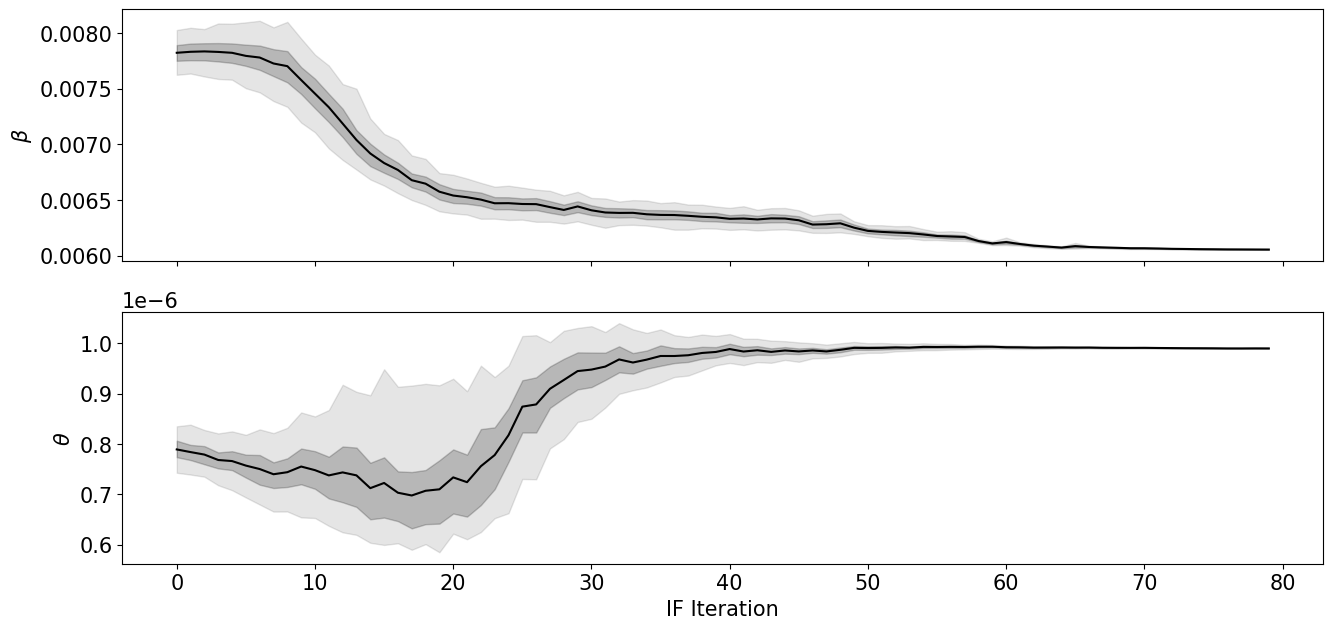

In [13]:
beta_df  = create_df_response(param_iter[0,:,:], time=80).reset_index()
theta_df = create_df_response(param_iter[1,:,:], time=80).reset_index()

fig, ax = plt.subplots(2, 1, figsize=(15.5, 7.2), sharex=True)

ax[0].plot(range(80), beta_df["mean"], color="k");    ax[0].fill_between(range(80), beta_df["up_95"], beta_df["low_95"], color="k", alpha=0.1);  ax[0].fill_between(range(80), beta_df["up_50"], beta_df["low_50"], color="k", alpha=0.2)
ax[1].plot(range(80), (theta_df["mean"]), color="k"); ax[1].fill_between(range(80), (theta_df["up_95"]), (theta_df["low_95"]), color="k", alpha=0.1); ax[1].fill_between(range(80), theta_df["up_50"], theta_df["low_50"], color="k", alpha=0.2)

ax[0].set_ylabel(r"$\beta$")
ax[1].set_ylabel(r"$\theta$")
ax[-1].set_xlabel("IF Iteration")

fig.savefig(os.path.join(results_dir, "figures", "model1", "convergence_plots_ifeakf.png"), dpi=300, transparent=True)


In [14]:
mle_df          = pd.DataFrame(columns=["type", "beta", "theta"])
mle_df["type"]  = ["mean", "variance"]
mle_df["beta"]  = [param_iter[0,:,-1].mean(), param_iter[0,:,-1].var()]
mle_df["theta"] = [param_iter[1,:,-1].mean(), param_iter[1,:,-1].var()]


pop   = 200e6
dates = if2_settings["dates_simulation"]


# Simulate with MLE
S0     = np.squeeze(pop * sample_params_uniform(state_params_range, m))
C0     = np.squeeze((1 - sample_params_uniform(state_params_range, m))*pop)
I0     = np.random.uniform(1e-9, 0.01 / 100, m )*pop

inc    = np.zeros(( m))
x0     = np.array([S0, C0, I0, inc]) # array with initial conditions [num_state_variables, num_age_groups]
x      = x0

betas        = np.ones((m)) * mle_df[mle_df.type=="mean"]["beta"].values[0]
thetas       = np.ones((m)) * mle_df[mle_df.type=="mean"]["theta"].values[0]

x_time = np.full((n, m, len(dates_assimilation)+1), np.nan)
x_time[:,:,0] = x

for idx_t, date in enumerate(dates_assimilation):
    # Integrate model
    x_time[:, :, idx_t+1] = imd_model(x_time[:,:,idx_t], betas, thetas, N=population, dt=30)

S   = x_time[0, :, 1:];  S_df = create_df_response(S, time= num_steps);     S_df["date"] = dates_assimilation
C   = x_time[1, :, 1:];  C_df = create_df_response(C, time= num_steps);     C_df["date"] = dates_assimilation
I   = x_time[2, :, 1:];  I_df = create_df_response(I, time= num_steps);     I_df["date"] = dates_assimilation
inc = x_time[3, :, 1:];  inc_df = create_df_response(inc, time= num_steps); inc_df["date"] = dates_assimilation

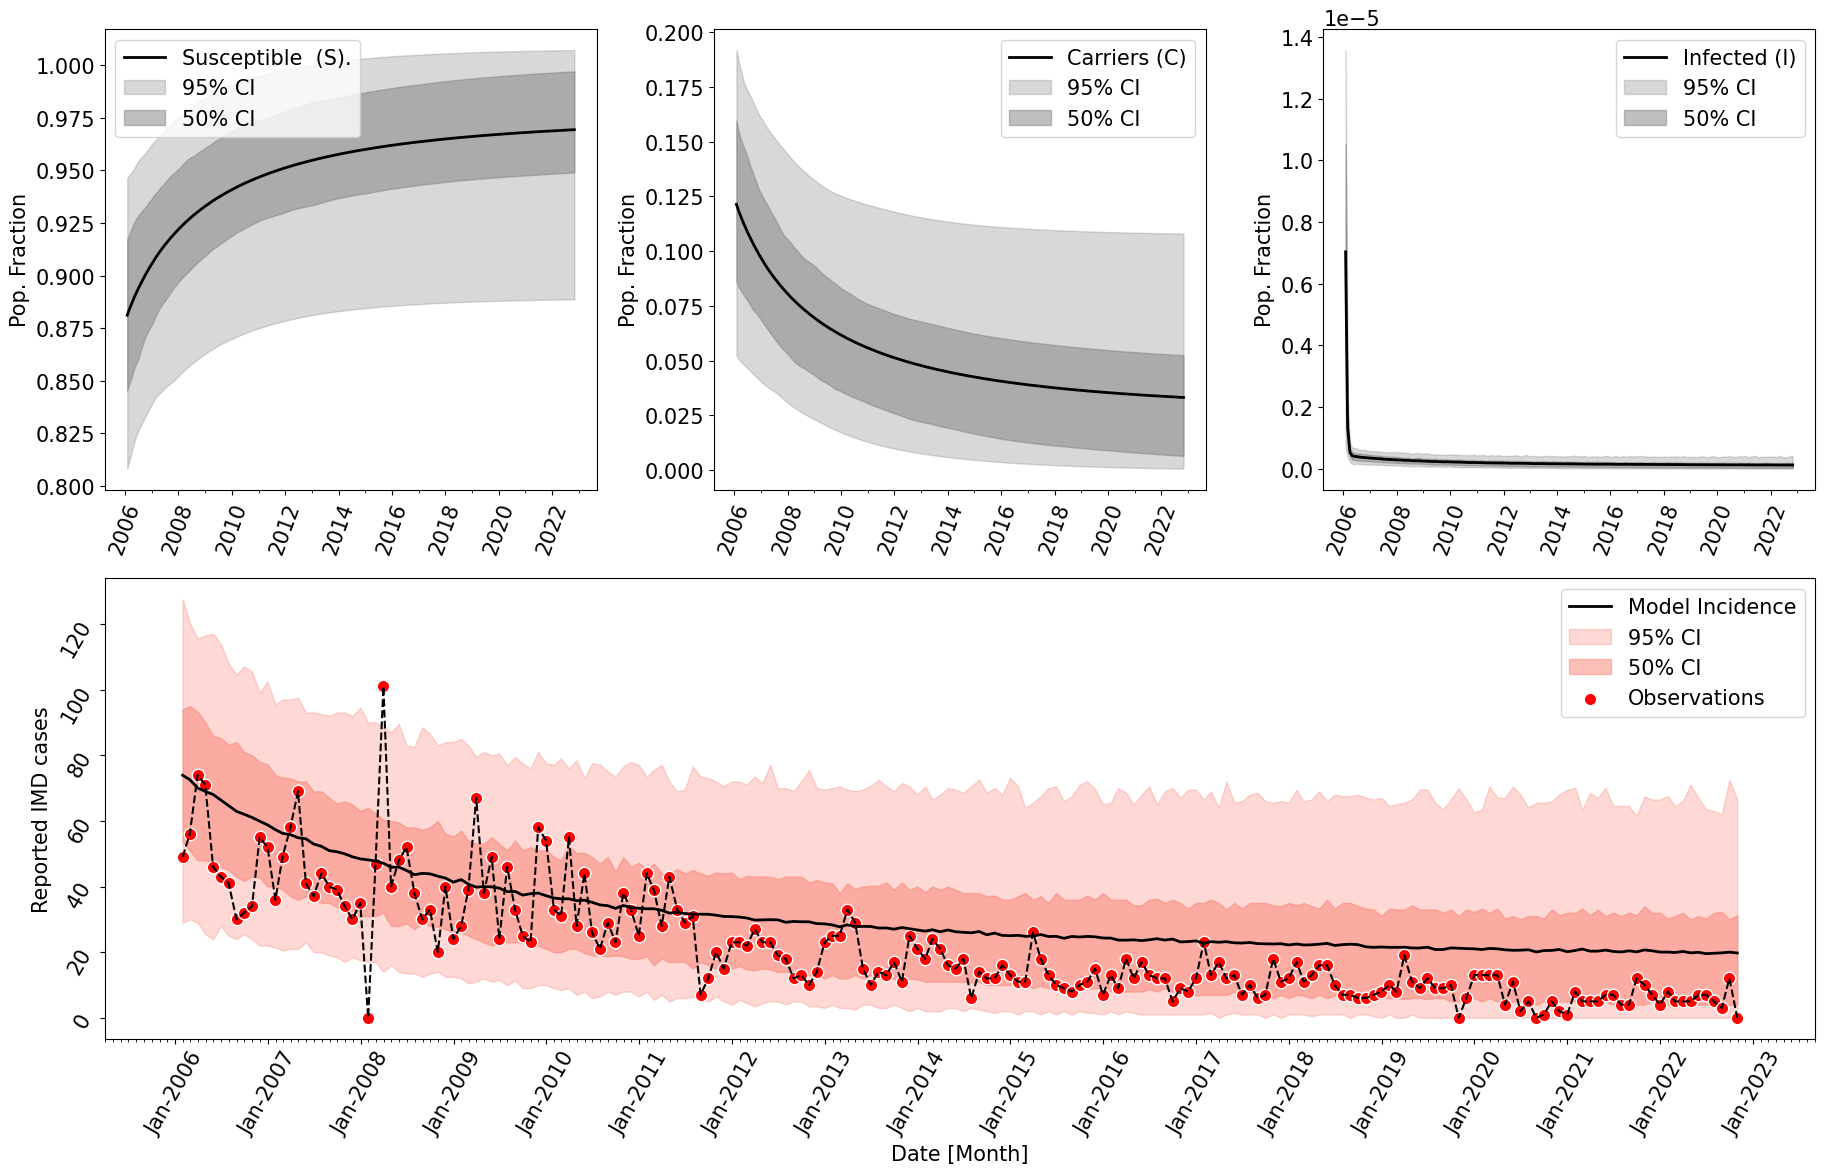

In [15]:


fig = plt.figure(figsize=(18.5, 12))

ax1 = plt.subplot(231)
ax2 = plt.subplot(232)
ax3 = plt.subplot(233)
ax4 = plt.subplot(212)

ax1.plot(S_df.date,         S_df["mean"]   / population, color="k", lw=2, label="Susceptible  (S).")
ax1.fill_between(S_df.date, S_df["low_95"] / population, S_df["up_95"] / population, color="gray", alpha=0.3, label="95% CI")
ax1.fill_between(S_df.date, S_df["low_50"] / population, S_df["up_50"] / population, color="gray", alpha=0.5, label="50% CI")
ax1.set_ylabel("Pop. Fraction")

ax2.plot(C_df.date,         C_df["mean"] / population, color="k", lw=2, label="Carriers (C)")
ax2.fill_between(C_df.date, C_df["low_95"] / population, C_df["up_95"] / population, color="gray", alpha=0.3, label="95% CI")
ax2.fill_between(C_df.date, C_df["low_50"] / population, C_df["up_50"] / population, color="gray", alpha=0.5, label="50% CI")
ax2.set_ylabel("Pop. Fraction")

ax3.plot(I_df.date, I_df["mean"]/population, color="k", lw=2, label="Infected (I)")
ax3.fill_between(I_df.date, I_df["low_95"]/population, I_df["up_95"]/population, color="gray", alpha=0.3, label="95% CI")
ax3.fill_between(I_df.date, I_df["low_50"]/population, I_df["up_50"]/population, color="gray", alpha=0.5, label="50% CI")
ax3.set_ylabel("Pop. Fraction")


ax4.plot(inc_df.date, inc_df["mean"], color="k", lw=2, label="Model Incidence")
ax4.fill_between(inc_df.date, inc_df["low_95"], inc_df["up_95"], color="salmon", alpha=0.3, label="95% CI")
ax4.fill_between(inc_df.date, inc_df["low_50"], inc_df["up_50"], color="salmon", alpha=0.5, label="50% CI")

ax4.scatter(obs_df.index.values, obs_df["confirmed"], ec="white", fc="red", s=80, label="Observations")
ax4.plot(obs_df.index.values, obs_df["confirmed"], linestyle="--", color="k")

ax4.set_ylabel("Reported IMD cases")

ax1.legend()
ax2.legend()
ax3.legend()

for axi in [ax1, ax2, ax3]:
    axi.tick_params(which='both', axis='x', labelrotation=70, labelsize=15)
    axi.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    axi.xaxis.set_minor_locator(mdates.YearLocator())

ax4.tick_params(which='both', axis='both', labelrotation=60, labelsize=15)
ax4.xaxis.set_major_formatter(mdates.DateFormatter('%b-%Y'))
ax4.xaxis.set_minor_locator(mdates.MonthLocator())
ax4.xaxis.set_major_locator(mdates.YearLocator())
ax4.set_xlabel("Date [Month]")
ax4.legend(loc="upper right")
plt.tight_layout()

fig.savefig(os.path.join(results_dir, "figures", "model1", "ifeakf_sim.png"), dpi=300, transparent=True)


In [16]:
def forecast_eakf(data_df, forecast_horizon=6):
        data_assimilation_df  = data_df.copy()
        data_assimilation_df  = data_assimilation_df.set_index("date").drop_duplicates()
        dates_assimilation    = data_assimilation_df.index.values

        idx_date_update = 0

        dict_params_range = {}
        dict_params_range["beta"]  = [βmin, βmax]
        dict_params_range["theta"] = [θmin, θmax]

        state_params_range       = {}
        state_params_range["S0"] = [75/100, 95/100]


        param_prior = sample_params_uniform(dict_params_range, m)

        obs_t = np.zeros((m))

        p = 2
        n = 4

        num_steps        = len(data_assimilation_df)
        param_post_time  = np.zeros((p, m,    num_steps))
        x_post_time      = np.zeros((n, m, num_steps))
        obs_post_time    = np.zeros((1, m, num_steps))

        idx_date_update   = 0

        obs_t         = np.zeros((m))

        S0     = np.squeeze(population * sample_params_uniform(state_params_range, m))
        C0     = np.squeeze((1 - sample_params_uniform(state_params_range, m))*population)
        I0     = np.zeros(( m))

        inc    = np.zeros(( m))
        x0     = np.array([S0, C0, I0, inc]) # array with initial conditions [num_state_variables, num_age_groups]
        x      = x0


        x_prior = np.zeros((n, m))

        for idx_date, date in tqdm(enumerate(dates_assimilation)):
                betas  = param_prior[0, :].copy()
                thetas = param_prior[1, :].copy()

                x_prior = imd_model(x, betas, thetas, N=population, dt=30)
                x = x_prior.copy()
                obs        = x[-1,:]
                obs_t      += obs

                # Since the age groups are an index, the arrangement of the age groups remains.
                oev_confirmed_time = data_assimilation_df.loc[date]["oev"]
                confirmed_time     = data_assimilation_df.loc[date]["confirmed"]

                x_post, param_post, obs_post = eakf_step(x_prior, param_prior, obs_t, confirmed_time, oev_confirmed_time, dict_params_range, num_var=n)
                S       = x_post[0, :] # Susceptible  [1, num_ensembles]
                C       = x_post[1, :] # Carriers     [1, num_ensembles]
                I       = x_post[2, :] # Infected     [1, num_ensembles]
                x_post[0, :] = population*np.ones(S.shape) - C - I # re-adjust susceptibility

                x_post                       = checkbound_state_vars(x_post, population)
                param_post                   = checkbound_params(dict_params_range, param_post, num_ensembles=300)
                x = x_post.copy()

                # Use posterior and next prior
                param_prior                          = param_post.copy()
                obs_post_time[:,:,idx_date_update]   = obs_post
                param_post_time[:,:,idx_date_update] = param_prior
                x_post_time[:,:,idx_date_update]     = x_post
                idx_date_update += 1
                obs_t           = np.zeros((m))

        betas  = param_post_time[0,:,-1]
        thetas = param_post_time[1,:,-1]

        x_forecast = np.full((forecast_horizon+1, n, m), np.nan)
        x_forecast[0,:,:] = x

        from dateutil.relativedelta import relativedelta

        dates_forecasts = pd.date_range(start=pd.to_datetime(dates_assimilation[-1])+ relativedelta(months=1), periods=forecast_horizon, freq="M")

        for idx_forecast, date_forecast in enumerate(range(forecast_horizon)):
                x_forecast[idx_forecast+1,:,:] = imd_model(x_forecast[idx_forecast,:,:], betas, thetas, N=population, dt=30)

        forecast_df = create_df_response(x_forecast[1:, -1, :].T, time=forecast_horizon, quantiles=[5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 97.5]).reset_index(); forecast_df.date=dates_forecasts

        return x_forecast, forecast_df



In [17]:
dates_forecasts = obs_df.reset_index().date[11:].values
date_init       = obs_df.reset_index().date.iloc[0]

FORECAST_MONTHS = 6
path_to_save_forecast = os.path.join(results_dir, "forecast", "eakf_model1")
os.makedirs(path_to_save_forecast, exist_ok=True)

In [18]:
for idx, date in tqdm(enumerate(dates_forecasts), total=len(dates_forecasts)):

    ts = pd.to_datetime(str(date))
    d = ts.strftime('%Y-%m-%d')

    # if os.path.isfile(os.path.join(path_to_save_forecast, f"{d}.csv")):
    #     continue

    usa_df         = obs_df.reset_index()
    dates_use      = pd.date_range(start=date_init, end=date, freq="M")
    fit_data       = usa_df[usa_df.date.isin((list(dates_use)))]
    _, forecast_df = forecast_eakf(fit_data, forecast_horizon=4*6)

    forecast_df["forecast_date"] = date
    forecast_df["add"] = 0
    forecast_df.to_csv(os.path.join(path_to_save_forecast, f"{d}.csv"))


12it [00:00, 256.44it/s]00:00<?, ?it/s]
13it [00:00, 255.70it/s]00:00<00:45,  4.20it/s]
13it [00:00, 310.25it/s]00:00<00:37,  4.98it/s]
14it [00:00, 334.95it/s]00:00<00:31,  5.92it/s]
15it [00:00, 391.50it/s]00:00<00:30,  6.16it/s]
15it [00:00, 444.83it/s]00:00<00:28,  6.63it/s]
16it [00:00, 351.72it/s]00:00<00:26,  6.90it/s]
17it [00:00, 460.86it/s]00:01<00:25,  7.10it/s]
18it [00:00, 451.07it/s]00:01<00:25,  7.19it/s]
19it [00:00, 440.58it/s]00:01<00:24,  7.48it/s]
19it [00:00, 446.55it/s][00:01<00:23,  7.57it/s]
19it [00:00, 339.95it/s][00:01<00:24,  7.45it/s]
20it [00:00, 444.98it/s][00:01<00:24,  7.19it/s]
21it [00:00, 389.10it/s][00:01<00:25,  7.08it/s]
22it [00:00, 337.98it/s][00:02<00:26,  6.77it/s]
23it [00:00, 507.31it/s][00:02<00:26,  6.58it/s]
23it [00:00, 481.47it/s][00:02<00:25,  6.94it/s]
24it [00:00, 529.42it/s][00:02<00:23,  7.26it/s]
24it [00:00, 420.90it/s][00:02<00:23,  7.48it/s]
25it [00:00, 463.84it/s][00:02<00:23,  7.32it/s]
25it [00:00, 445.45it/s][00:02<00:23, 